# Ising Decimation Reversion with CNN 

The C++ code generates a set of ising spin configurations. This set of spin configuration is decimated by a majority rule method. This cuts the system size to its half. Then the decimated spin configuration is resized by simple block duplication. Now the system size is back to its original. A convolutional neural network model is trained to match the observables (absolute magnetization, energy, spin-spin correlation function) of newly generated spin configurations to the original one. For some observables (energy, spin-spin correlation function), it can be compared with an analytic solution.

## Initialization and Preprocessing

Most of the preprocessing already happened in the C++ code. The focus here is on loading the data in an appropriate manner. The padding of the CNN model is intended to work periodically. This is not implemented by the python library Tensorflow and is therefore part of the preprocessing in this notebook.

In [1]:
#Code Written by Jan Zimbelmann

################
#initialization#
################

#importing libraries
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.framework import ops
import random
from tensorflow.keras.callbacks import EarlyStopping
tf.keras.backend.set_floatx('float64')

#calculation boundary conditions
#code requires the c++ MC code to be run before, for the same or larger steps range (0,1,...,steps)
L=32 #system length
data_points = 10
dist = 3 #distance for two point spin correlation function
K = np.array(list(range(3,33,3))) #inverse temperature (needs later to be devided by 10)
steps = 0 #enlarging steps, used in future code

#neural network boundary conditions
EPOCHS = 4000 #large amount of epochs, intented to be stopped by early stopping
BATCH_SIZE = 1000
bestOf = 2 #repeating the training a certain amount
lr = 1e-3 #learning rate

#padding configurations
padding_sizes = [15,15,15] #hidden layers
padding_size = len(padding_sizes) #length of all padding sizes
padding_sum = sum(padding_sizes)-padding_size #length of the padding that needs to be removed
print(padding_sum)

#folders
folder_cp = 'checkpoints/' #weights and biases saving folder
folder_mc = 'configurations/' #configurations folder
folder_nn = 'reconstructions/' #folder for the CNN reconstruction data

###########
#functions#
###########

#initiate the neural network model
def create_model(inp):
    model = models.Sequential()
    total_padding = padding_sum
    for a in range(padding_size-1):
        model.add(layers.Conv1D(1, padding_sizes[a], activation = lambda x : tf.nn.elu(x), input_shape=(inp+total_padding,1)))
        total_padding -= padding_sizes[a]-1
    model.add(layers.Conv1D(1, padding_sizes[-1], activation='sigmoid', input_shape=(inp+total_padding,1)))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                     loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

#periodic boundary condition padding construction
def cut(number,length):
    if(number<length):
        return number
    else:
        return length
    
def pbcPadding(array, size):
    arrayNP = np.array(array)
    [dp, cfgs, lng] = arrayNP.shape
    column = np.empty([dp,cfgs,0])
    new_size = size
    for i in range(int((size/lng)-1e-50)+1):
        column = np.append(column,arrayNP[:,:,:cut(new_size,lng)],axis=2)
        new_size -= lng
    return np.append(arrayNP, column,axis=2)

#observables
def getM(array): #absolute magnetization
    m = 0
    for i in array:
        m += (i*2)-1
    return abs(m)

def getE(array): #energy
    e = 0
    size = len(array)
    for i in range(size):
        e += ((array[i]*2)-1) * ((array[(i+1)%size]*2)-1)
    return -e

def getG(array, j): #two point spin-spin correlation
    g = 0
    amount = 0
    size = len(array)
    for i in range(size):
        g += (array[i]*2-1)*(array[(i+j)%size]*2-1)
    return g/(size)

def getK(array, amount): #inverse temperature transformation
    beta = np.array(array)
    for i in range(amount):
        beta = 0.5*np.arccosh(np.exp(2*beta))
    return beta

42


In [2]:
###########################################
#store spin configurations and observables#
###########################################

#load observables Monte Carlo .csv data
    
#data preperation
mcS, train_mcS, test_mcS = [],[],[] #load monte carlo configurations
rgS, train_rgS, test_rgS = [],[],[] #load decimated MC configurations
test_mdS = [] #create array for configurations for testing the reconstruction

for i in range(data_points):
    k=K[i] #inverse temperature
    
    mcName = 'z'+str(0)+'Mc'+str(k)+'L'+str(L)+'.csv'
    rgName = 'z'+str(0)+'Mr'+str(k)+'L'+str(L)+'.csv'

    mcS.append(np.array(np.loadtxt(folder_mc + mcName, delimiter =',')))
    train_size = int(len(mcS[i])/2)
    test_size = int(len(mcS[i])-train_size)
    size = train_size+test_size

    train_mcS.append(mcS[i][:train_size])
    test_mcS.append(mcS[i][train_size:])

    rgSpin = np.array(np.loadtxt(folder_mc + rgName, delimiter =','))
    rgS.append(rgSpin)

    test_mdS.append(np.empty([bestOf,test_size,L]))
    

rgS = pbcPadding(rgS,padding_sum)
train_rgS = rgS[:,:train_size]
test_rgS = rgS[:,test_size:]

#The following observables are for multiple enlargening steps:
#(example: L=32, L=64, L=128, ...) 
mcK = []
mcM = []
mcE = []
mcG = []

#loading .csv data
name_mc = 'z'+str(0)+'McL'+str(L)+'.csv'
MC = np.loadtxt(folder_mc + name_mc, delimiter =',')
mcK.append(MC[:,0])
mcM.append(MC[:,1])
mcE.append(MC[:,2])
mcG.append(MC[:,3])

## Learning Model

The CNN is trained with the cross-entropy loss functon and the Adam optimizer on the decimated configuration set to match the original configuration. The model is (preferably) stopped with an early stopper. A model is trained for each inverse temperature data point. The model training checkpoints and reconstructed configurations are saved.

In [3]:
#create model array for training
model_train = [ [ 0 for y in range(bestOf) ] for x in range(data_points) ]
checkpoint_path = [ [ None for y in range(bestOf) ] for x in range(data_points) ]

mdE = np.empty([data_points,bestOf])
mdM = np.empty([data_points,bestOf])

model_dif = np.empty([data_points,bestOf])
best_choice = []

##########
#training#
##########

tf.get_logger().setLevel('INFO')
for i in range(data_points):
    print('Beta = %s, Monte Carlo solution: \t |M| = %s \t E = %s'%(K[i], mcM[0][i], mcE[0][i]))
    for j in range(bestOf):
        model_train[i][j] = create_model(L)
        checkpoint_path[i][j] = folder_cp + "K"+ str(K[i])+"cp" + str(j) + ".ckpt"
        cb= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path[i][j],
                                                 save_weights_only=True,
                                                 verbose=0)
        es = EarlyStopping(monitor='loss', mode='min',verbose = 1, patience = 15, min_delta = 0)
        model_train[i][j].fit(train_rgS[i].reshape(train_size,32+padding_sum,1),
                 train_mcS[i].reshape(train_size,32,1),
                 batch_size = BATCH_SIZE, epochs=EPOCHS, verbose=0, callbacks=[cb,es])
        output = model_train[i][j](test_rgS[i]).numpy().reshape(test_size,32)
        for a, spin in enumerate(output):
            for b in range(L):
                r = random.uniform(0,1)
                condition = spin[b]
                if(r>condition):
                    test_mdS[i][j][a][b] = 0
                else:
                    test_mdS[i][j][a][b] = 1
        
        #calculate observable of the model to measure some accuracy
        #used to decide which model is the best for bestOf > 1
        partM = 0
        partE = 0
        for a in test_mdS[i][j]:
            partM += getM(a)
            partE += getE(a)

        partM /= test_size
        partE /= test_size

        print("Beta = %s, Model %s learned: \t  \t |M| = %s \t E = %s"%(K[i], j, partM, partE))
        
        mdM[i][j]= partM
        mdE[i][j] = partE
        model_dif[i][j] = abs(mcE[0][i] - mdE[i][j]) + abs(mcM[0][i] - mdM[i][j])
    best_choice.append(np.argmin(model_dif[i]))
    model_train[i][best_choice[i]].save_weights('./checkpoints/'+str(K[i]))
    print('best choice is the model with the index %s \n'%(best_choice[i]))

np.savetxt(folder_cp+'best_choice.csv', best_choice, fmt='%i', delimiter = ',')

Beta = 3, Monte Carlo solution: 	 |M| = 6.0978 	 E = -9.34013
Epoch 01005: early stopping
Beta = 3, Model 0 learned: 	  	 |M| = 6.0676 	 E = -9.312
Epoch 00547: early stopping
Beta = 3, Model 1 learned: 	  	 |M| = 6.0946 	 E = -9.372
best choice is the model with the index 1 

Beta = 6, Monte Carlo solution: 	 |M| = 8.29192 	 E = -17.1743
Epoch 00695: early stopping
Beta = 6, Model 0 learned: 	  	 |M| = 8.2962 	 E = -17.1656
Epoch 00849: early stopping
Beta = 6, Model 1 learned: 	  	 |M| = 8.2854 	 E = -17.1152
best choice is the model with the index 0 

Beta = 9, Monte Carlo solution: 	 |M| = 11.312 	 E = -22.9111
Epoch 01345: early stopping
Beta = 9, Model 0 learned: 	  	 |M| = 11.2972 	 E = -22.8908
Epoch 01366: early stopping
Beta = 9, Model 1 learned: 	  	 |M| = 11.3582 	 E = -22.9376
best choice is the model with the index 0 

Beta = 12, Monte Carlo solution: 	 |M| = 15.9542 	 E = -26.7572
Epoch 02160: early stopping
Beta = 12, Model 0 learned: 	  	 |M| = 15.903 	 E = -26.7436
Ep

In [4]:
#saving previously calculated best neural network construction to test_nnS

nnE = [[]]
nnM = [[]]
nnG = [[]]
test_nnS = [[]]

#load best model which had been calculated previously,
#used for jupyter-notebook, here commented:
#best_choice = np.loadtxt(folder_cp + 'best_choice.csv', delimiter =',', dtype='int')

for i in range(data_points):
    test_nnS[0].append(test_mdS[i][best_choice[i]])
    partE = 0
    partM = 0
    partG = 0
    for a in test_nnS[0][i]:
        partE += getE(a)
        partM += getM(a)
        partG += getG(a,dist)
    nnE[0].append(partE / test_size)
    nnM[0].append(partM / test_size)
    nnG[0].append(partG / test_size)

In [5]:
#saving the data and also calculating the inverse temperature transformation
#create cnn reconstruction configurations folder
if not os.path.exists(folder_nn):
    os.makedirs(folder_nn)

nnK = []
target =0
#saving observables
#calculate temperature transformation
nnK.append(getK(K/10,target))
obs = [] #observables array for saving
obs.append(nnK[target])
obs.append(nnM[target])
obs.append(nnE[target])
obs.append(nnG[target])
obs = np.array(obs).transpose()
name = 'z'+str(target)+'Nn'+ 'L' + str(L) + '.csv'
np.savetxt(folder_nn + name, obs, delimiter = ',')
#saving spin configurations
for i in range(data_points):
    name = 'z' + str(target) + 'Nn' + str(K[i]) + 'L' + str(L) + '.csv'
    np.savetxt(folder_nn + name, test_nnS[target][i], fmt='%i', delimiter = ',')

## Visualization

The results of the previous learning algorithm is visualized with matplotlib. There are also analytical solutions calculated to verify the simulated once. The error is plotted as well.

In [6]:
#there are analytic solutions for the 1D Ising model for E and G
anK = []
anE = []
anG = []
for i in range(100):
    beta = ((i*(max(K/10)-min(K/10)))/99)+min(K/10)
    anK.append(beta)
    anE.append(-(L*np.sinh(beta)*np.cosh(beta)*((np.sinh(beta)**(L-2))+(np.cosh(beta)**(L-2))))/((np.sinh(beta)**L)+(np.cosh(beta)**L)))
    G = ((np.tanh(beta)**dist) + (np.tanh(beta)**(L-dist)))/(1+(np.tanh(beta)**L))
    anG.append(G)
anK = np.array(anK)
anE = np.array(anE)
anG = np.array(anG)

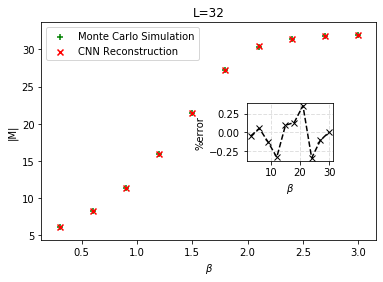

In [7]:
#plotting the MC, CNN reconstructed and analytic solution for the absolute magnetization
plt.scatter(K/10, mcM,color='green', marker = '+', label = "Monte Carlo Simulation")
plt.scatter(K/10, nnM,color='red', marker = 'x', label = 'CNN Reconstruction')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel('|M|')
plt.title('L='+str(L))

a = plt.axes([.6, .4, .2, .2])
plt.plot(K, 100*((nnM[0]-mcM[0])/abs(mcM[0])),  linestyle='--', marker='x', color = 'black')
plt.xlabel(r'$\beta$')
plt.ylabel('%error')      
plt.grid(color='0.88', linestyle = '--', linewidth = 1)

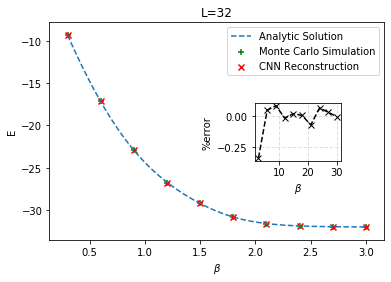

In [8]:
plt.show()

#plotting the MC, CNN reconstructed and analytic solution for the energy
plt.plot(anK, anE, linestyle = 'dashed', label = 'Analytic Solution')
plt.scatter(K/10, mcE[0],color='green', marker = '+', label = "Monte Carlo Simulation")
plt.scatter(K/10, nnE[0],color='red', marker = 'x', label = 'CNN Reconstruction')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel('E')
plt.title('L='+str(L))

a = plt.axes([.6, .4, .2, .2])
plt.plot(K, 100*((nnE[0]-mcE[0])/abs(mcE[0])),  linestyle='--', marker='x', color = 'black')
plt.xlabel(r'$\beta$')
plt.ylabel('%error')      
plt.grid(color='0.88', linestyle = '--', linewidth = 1)

plt.show()

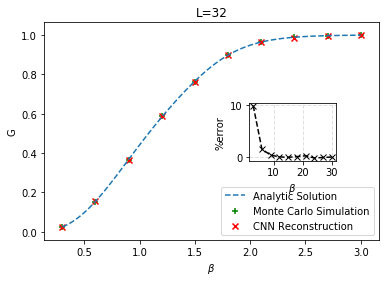

In [9]:
#plotting the MC, CNN reconstructed and analytic solution for the spin-spin correlation function
plt.plot(anK, anG, linestyle = 'dashed', label = 'Analytic Solution')
plt.scatter(K/10, mcG,color='green', marker = '+', label = "Monte Carlo Simulation")
plt.scatter(K/10, nnG,color='red', marker = 'x', label = 'CNN Reconstruction')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel('G')
plt.title('L='+str(L))

a = plt.axes([.6, .4, .2, .2])
plt.plot(K, 100*((nnG[0]-mcG[0])/abs(mcG[0])),  linestyle='--', marker='x', color = 'black')
plt.xlabel(r'$\beta$')
plt.ylabel('%error')      
plt.grid(color='0.88', linestyle = '--', linewidth = 1)

plt.show()

## Discussion

The CNN model was able to reconstruct the observables with a less mistake of the observables than <1% and is therefore able to make to revert the information loss from the decimation procedure. This is a groundwork for resizing to larger system sizes.